In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class DigitRecognition:
    '''Class for a handwritten digit'''
    
    def __init__(self,train_file,test_file,nHidden=100,nRepeat=10):
        
        # Possible outputs
        self.f=[0,1,2,3,4,5,6,7,8,9]
        
        self.nRepeat=nRepeat # Number of times to repeat training set

        # Get the training set
        self.trainSet,self.scaleTrainSet,self.num = self.get_digit_set(train_file,nRepeat)
        
        self.nHidden=nHidden # Size of hidden layer
        self.nInX=len(self.scaleTrainSet[0]) # Size of the input arrayn
        self.nTrain=len(self.trainSet) # Number of unique training data
        self.nTrain_rep=self.nTrain*nRepeat # Number of total training sets

        # Set the alpha values
        self.alpha=10./self.nInX
        self.alphaBar=20./self.nHidden # Suggested value from Franklin
        
        # Train the model to get A and B
        self.A,self.B=self.train_neural_net()
        
        # Get the residual and list of final predictions
        self.resid,self.predict=self.get_resid(self.scaleTrainSet,self.num,self.nTrain)
        
        # Get test set
        self.testSet,self.scaleTestSet,self.numTest = self.get_digit_set(test_file,1)
        
        # Get residual of test set
        self.residTest,self.predictTest=self.get_resid(self.scaleTestSet,self.numTest,len(self.testSet))
        
        
    def get_digit_set(self,fileName,nRepeat):
        '''Get a set of digits'''
        
        # Read in digits into arrays
        with open(fileName) as file:
            digits = file.readlines()
            digits = [np.array(digit.rstrip().split(","),dtype='float') for digit in digits]
        
        # Make data range from 0.01 to 1.00, and select out the correct number (first entry)
        scaled_digits=[]
        num=[]
        for digit in digits:
            scaled_digits.append(digit[1:]/255.0 * 0.99 + 0.01)
            num.append(digit[0])
            
        # Duplicate the training set
        scaled_digits_rep=scaled_digits.copy()
        num_rep=num.copy()
        for d in range(nRepeat):
            scaled_digits_rep+=scaled_digits.copy()
            num_rep+=num.copy()
        
        # Shuffle the training set
        _tmp_xz=list(zip(scaled_digits_rep,num_rep))
        random.shuffle(_tmp_xz)
        scaled_digits_rep,num_rep=zip(*_tmp_xz)
        
        return digits,scaled_digits_rep,num_rep
     
    def train_neural_net(self):
        '''Train the neural network'''
        
        # Tolerance and step size for convergence of the steepest descent
        tol=0.1
        eta=1.0
        
        # Randomly initialize A and B matrix. 
        # Length of output is size 10 array, length of input is 784 pixels for character
        A=np.random.rand(10,self.nHidden)
        B=np.random.rand(self.nHidden,self.nInX)
    
        for k in range(self.nTrain_rep):

            # Turn input number into bit array between 0.01 and 0.99
            yk=np.zeros(10)+0.01
            yk[int(self.num[k])]=0.99
            
            z_tilde=self.g(self.alpha,np.dot(B,self.scaleTrainSet[k]))-0.5
            zk=self.g(self.alphaBar,np.dot(A,z_tilde))

            nConv=0 # Keep track of number of steps to convergence
            while(np.dot((zk-yk),(zk-yk)) > tol):
                
                sigma=2*self.alphaBar*(zk-yk)*zk*(1.-zk) # 1x4 array
                delA=np.outer(sigma,z_tilde)

                sigma_tilde=self.alpha*(0.5+z_tilde)*(0.5-z_tilde) # 1 x nHidden array
                delB=np.outer(np.dot(sigma,A)*sigma_tilde,self.scaleTrainSet[k])
                
                A-=eta*delA
                B-=eta*delB
                
                z_tilde=self.g(self.alpha,np.dot(B,self.scaleTrainSet[k]))-0.5
                zk=self.g(self.alphaBar,np.dot(A,z_tilde))
                
                # Limit to 10000 steps. For lower k, runs into convergence issues
                nConv+=1
                nThresh=10000
                if nConv > nThresh:
                    print('WARNING: Trouble converging A and B matricies, stopped after',nThresh,'cycles.',k)
                    break

        return A,B
        
    def g(self,alpha,x):
        '''Sigmoid Nonlinear function'''
        return 1/(1+np.exp(-alpha*x))
    
    def apply(self,x):
        '''Apply the nerual net to some input x'''
        z_tilde=self.g(self.alpha,np.dot(self.B,np.array(x)))-0.5
        zk=self.g(self.alphaBar,np.dot(self.A,z_tilde))
        return zk
    
    def get_f_from_zT(self,zT):
        '''Convert the vector to a given f'''
        fs=[]
        for z in zT:
            fs.append(np.dot(z,self.f))
        return fs
    
    def get_resid(self,xT,zT,nData):
        '''Get the residual of some set of data'''
        
        resid=[]
        predict=[]
        for x in range(nData):
            
            # Get the predictions, convert to f
            gAx=self.apply(xT[x])
            pred=self.get_f_from_zT([gAx])
            predict.append(pred)

            # Calculate the residual
            resid.append(np.abs(pred-zT[x]))
    
        resid=np.ndarray.flatten(np.array(resid))
        
        return resid,predict
    
    def plot_digit(self,scaled_digit):
        '''Plot one of the handwritten digits'''
        plt.clf()
        plt.imshow(scaled_digit.reshape((28, 28)),
                   cmap="Greys", interpolation="nearest")
        
        

In [3]:
chars=DigitRecognition('mnist_train_small.csv','mnist_test_small.csv')

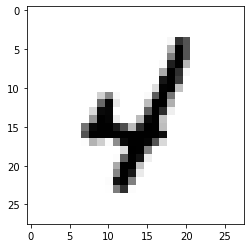

In [5]:
# Some examples of characters
nDigit=100
chars.plot_digit(chars.scaleTrainSet[nDigit])

plt.savefig('char_example'+str(int(chars.num[nDigit]))+'.pdf',bbox_inches='tight')

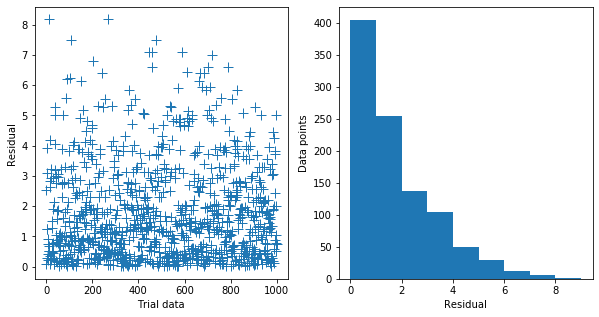

In [6]:
# Check residual of the training set
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

ax1.plot(np.array(chars.resid),'+',Markersize=10)
ax1.set_xlabel('Trial data')
ax1.set_ylabel('Residual')

ax2.hist(np.abs(np.array(chars.resid)),bins=[0,1,2,3,4,5,6,7,8,9])
ax2.set_xlabel('Residual')
ax2.set_ylabel('Data points')


plt.savefig('char_train_resid.pdf',bbox_inches='tight')
plt.show()

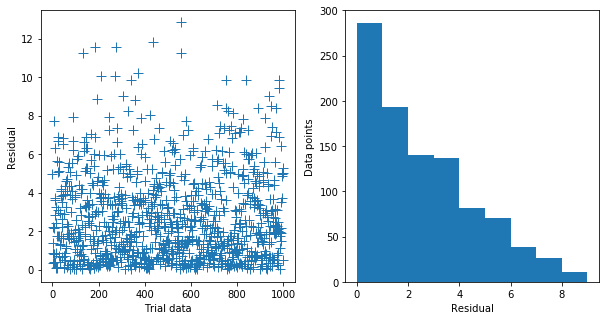

In [7]:
# Check residual of the test set
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

ax1.plot(np.array(chars.residTest),'+',Markersize=10)
ax1.set_xlabel('Trial data')
ax1.set_ylabel('Residual')

ax2.hist(np.abs(np.array(chars.residTest)),bins=[0,1,2,3,4,5,6,7,8,9])
ax2.set_xlabel('Residual')
ax2.set_ylabel('Data points')


plt.savefig('char_test_resid.pdf',bbox_inches='tight')
plt.show()